In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:

import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

base_dir = "/kaggle/input/breast-histopathology-images"

image_paths = []
labels = []

for patient_folder in os.listdir(base_dir):
    patient_path = os.path.join(base_dir, patient_folder)

    if not os.path.isdir(patient_path):
        continue
    for label_folder in ["0", "1"]:
        folder_path = os.path.join(patient_path, label_folder)

        if os.path.exists(folder_path):
            for img_file in os.listdir(folder_path):
                if img_file.endswith(".png"):
                    image_paths.append(os.path.join(folder_path, img_file))
                    labels.append(int(label_folder))

data_df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

print("Total number of samples:", len(data_df))
print(data_df.head())


print("The dataset is sampled balancedly...")
samples_per_class = 5000
df_0 = data_df[data_df['label'] == 0].sample(n=samples_per_class, random_state=42)
df_1 = data_df[data_df['label'] == 1].sample(n=samples_per_class, random_state=42)
data_df = pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"New balanced sample count: {len(data_df)}")
print(data_df['label'].value_counts())


Using Colab cache for faster access to the 'breast-histopathology-images' dataset.
Path to dataset files: /kaggle/input/breast-histopathology-images
Total number of samples: 277524
                                          image_path  label
0  /kaggle/input/breast-histopathology-images/102...      0
1  /kaggle/input/breast-histopathology-images/102...      0
2  /kaggle/input/breast-histopathology-images/102...      0
3  /kaggle/input/breast-histopathology-images/102...      0
4  /kaggle/input/breast-histopathology-images/102...      0
The dataset is sampled balancedly...
New balanced sample count: 10000
label
1    5000
0    5000
Name: count, dtype: int64



Starting data visualization...


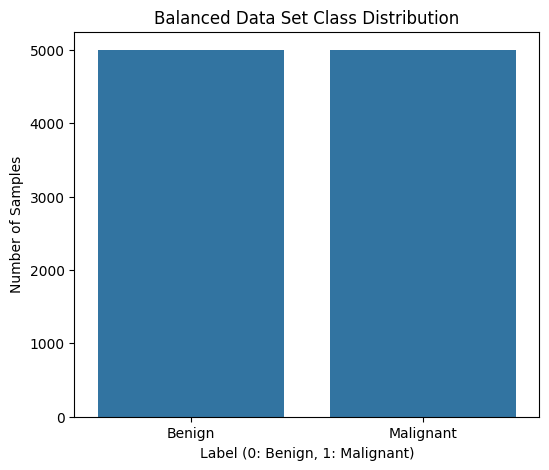

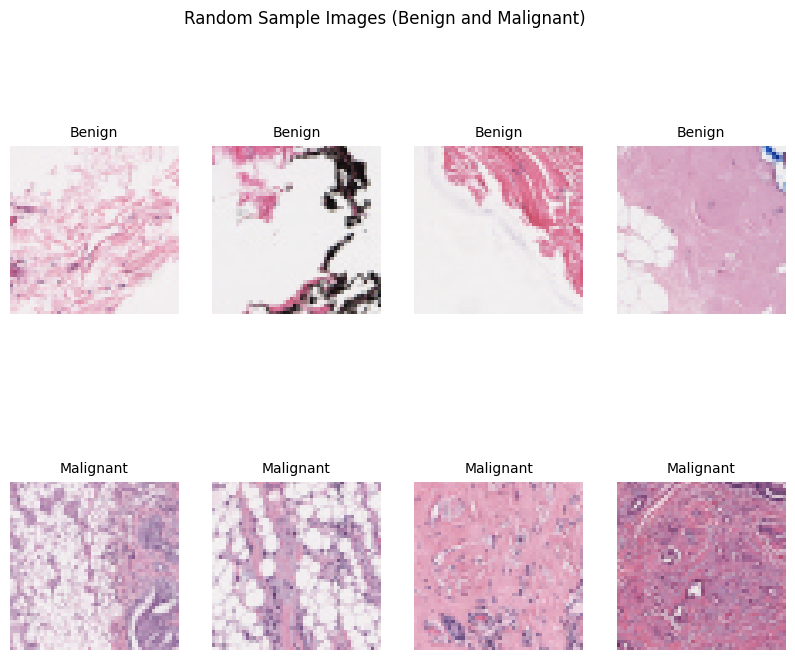

X shape: (10000, 128, 128, 3)
y shape: (10000,)
Train set: (8000, 128, 128, 3) (8000,)
Test set: (2000, 128, 128, 3) (2000,)
Data preparation is complete.


In [ ]:
print("\nStarting data visualization...")

plt.figure(figsize=(6, 5))
sns.countplot(x='label', data=data_df)
plt.title('Balanced Data Set Class Distribution')
plt.xlabel('Label (0: Benign, 1: Malignant)')
plt.ylabel('Number of Samples')
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.show()

plt.figure(figsize=(10, 8))
benign_samples = data_df[data_df['label'] == 0].sample(4, random_state=42)
malignant_samples = data_df[data_df['label'] == 1].sample(4, random_state=42)
sample_df = pd.concat([benign_samples, malignant_samples])

for i, (idx, row) in enumerate(sample_df.iterrows()):
    plt.subplot(2, 4, i + 1)
    img = load_img(row['image_path'])
    plt.imshow(img)
    plt.title(f"{'Malignant' if row['label'] == 1 else 'Benign'}", fontsize=10)
    plt.axis('off')
plt.suptitle('Random Sample Images (Benign and Malignant)')
plt.show()


IMG_SIZE = (128, 128)

X = []
y = []

for _, row in data_df.iterrows():
    try:
        img = load_img(row['image_path'], target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        X.append(img_array)
        y.append(row['label'])
    except Exception as e:
        print(f"Error occurred: {row['image_path']}, Mistake: {e}")

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)
print("Data preparation is complete.")

In [13]:
print("\nModel being created...")
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

print("\nModel training is starting...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train)//32,
    epochs=10,
    validation_data=(X_test, y_test)
)

# Modeli kaydet
model.save("breast_cancer_cnn_model.keras")
print("\nModel successfully saved: breast_cancer_cnn_model.keras")


Model being created...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)


Model training is starting...
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 276s 1s/step - accuracy: 0.6370 - loss: 0.6294 - val_accuracy: 0.7410 - val_loss: 0.6154
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - accuracy: 0.7743 - loss: 0.5044 - val_accuracy: 0.7885 - val_loss: 0.4888
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 320s 1s/step - accuracy: 0.8007 - loss: 0.4598 - val_accuracy: 0.8175 - val_loss: 0.4264
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8095 - loss: 0.4417 - val_accuracy: 0.8215 - val_loss: 0.4167
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.8073 - loss: 0.4479 - val_accuracy: 0.7845 - val_loss: 0.5049
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.8120 - loss: 0.4347 - val_accuracy: 0.8215 - val_loss: 0.4153
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.8028 - loss: 0.4493 - val_accuracy: 0.8160 - val_loss: 0.4103
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0


Model evaluation and predictions...


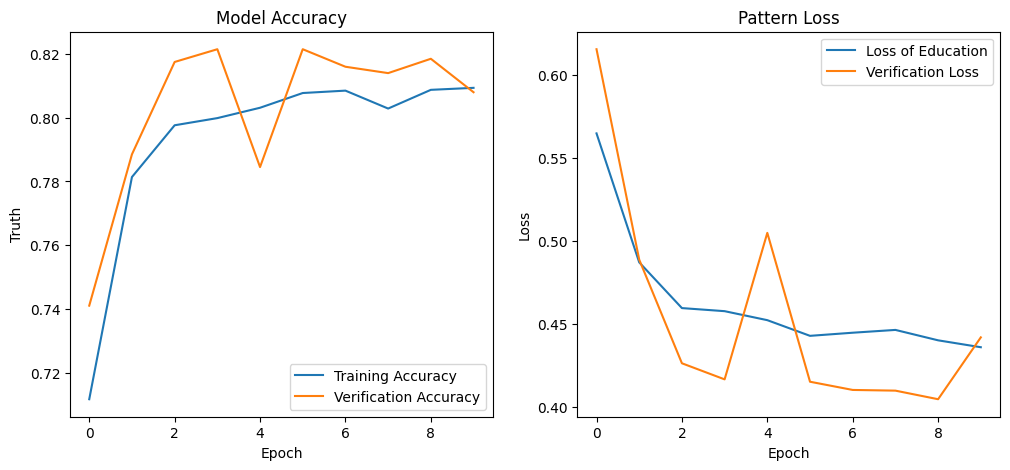

63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step
Classification Report:

              precision    recall  f1-score   support

      Benign       0.76      0.90      0.82      1000
   Malignant       0.87      0.72      0.79      1000

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



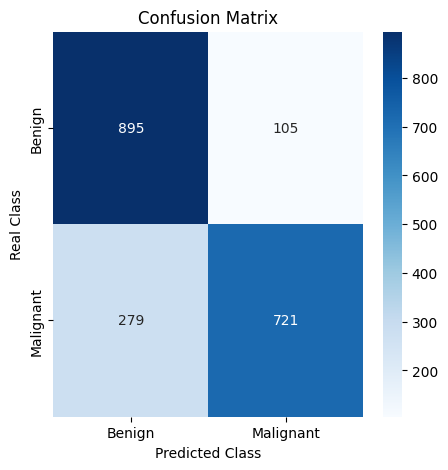

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


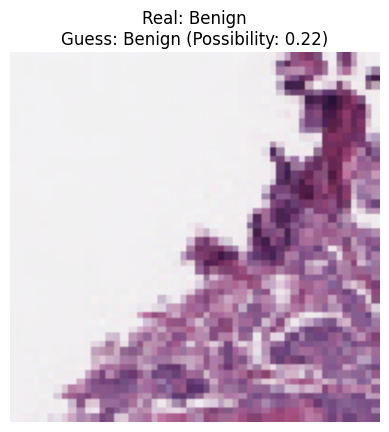

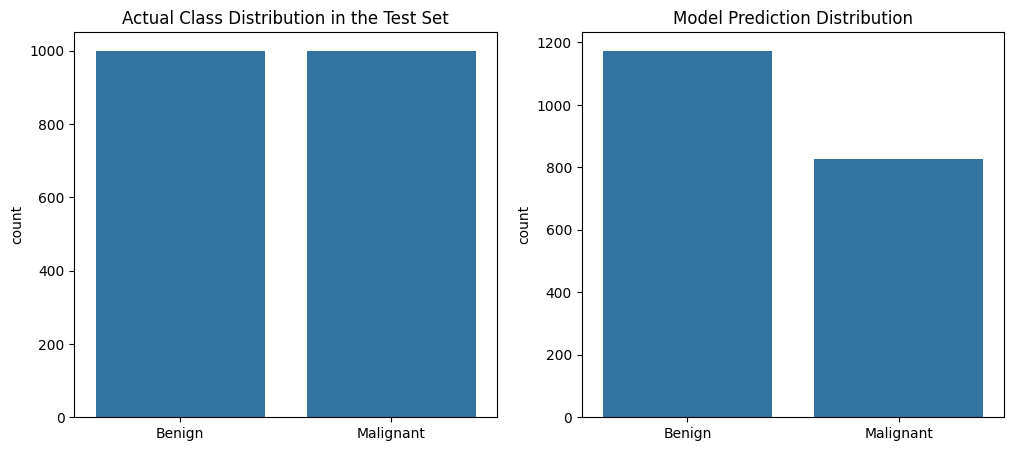

In [14]:
print("\nModel evaluation and predictions...")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Verification Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Truth')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss of Education')
plt.plot(history.history['val_loss'], label='Verification Loss')
plt.title('Pattern Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

report = classification_report(y_test, y_pred, target_names=["Benign","Malignant"])
print("Classification Report:\n")
print(report)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.title("Confusion Matrix")
plt.show()

idx = random.randint(0, len(X_test) - 1)
sample_img = X_test[idx].reshape(1, 128, 128, 3)
true_label = y_test[idx]

pred_prob = model.predict(sample_img)[0][0]
pred_label = 1 if pred_prob > 0.5 else 0

plt.imshow(X_test[idx])
plt.axis("off")
plt.title(
    f"Real: {'Benign' if true_label==0 else 'Malignant'}\n"
    f"Guess: {'Benign' if pred_label==0 else 'Malignant'} (Possibility: {pred_prob:.2f})"
)
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.countplot(x=y_test)
plt.xticks([0,1], ["Benign", "Malignant"])
plt.title("Actual Class Distribution in the Test Set")

plt.subplot(1,2,2)
sns.countplot(x=y_pred.flatten())
plt.xticks([0,1], ["Benign", "Malignant"])
plt.title("Model Prediction Distribution")
plt.show()



CHAPTER 5: Initiating Advanced Assessment and Improvement Techniques...

Calculating ROC Curve and AUC...


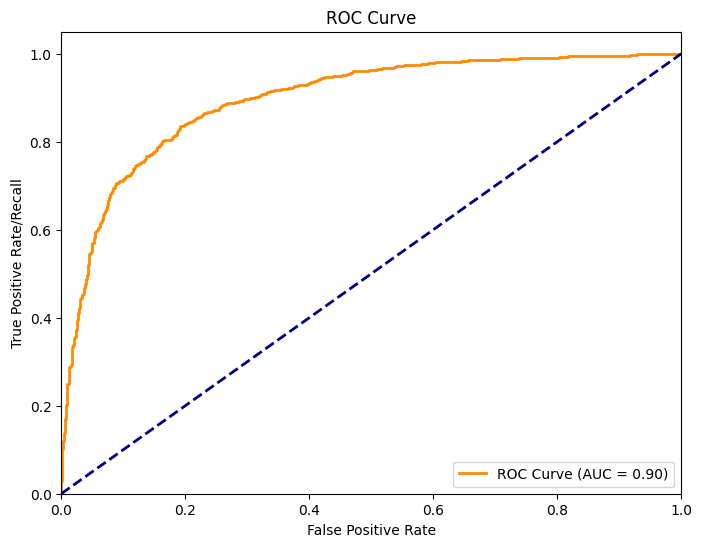

Test Set AUC Value: 0.8961

Precision-Recall Curve Analysis...


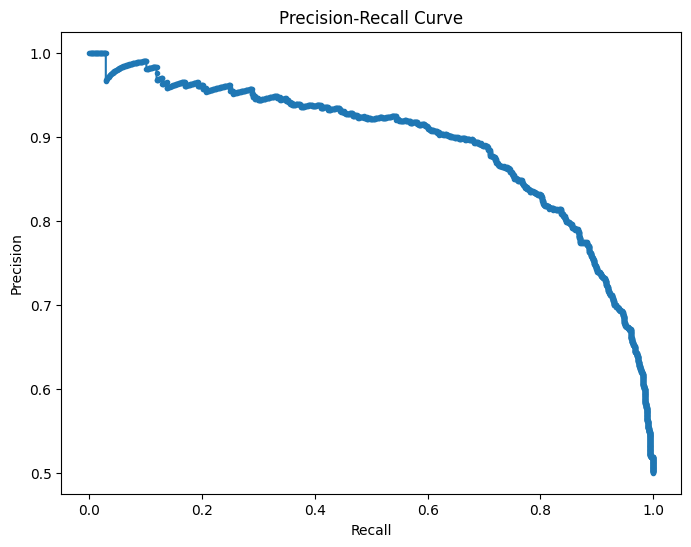

In [15]:
print("\nCHAPTER 5: Initiating Advanced Assessment and Improvement Techniques...")

from sklearn.metrics import roc_curve, auc

print("\nCalculating ROC Curve and AUC...")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate/Recall')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
print(f"Test Set AUC Value: {roc_auc:.4f}")

from sklearn.metrics import precision_recall_curve

print("\nPrecision-Recall Curve Analysis...")
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()